# User Analysis

In here we are analysing the data in `data/users/`. Before pre-processing, **we have 341,018 users** that appear in our games network found in `data/games/network_raw`. 

After processing our dataframe so that we remove users that have invalid signup dates, **we now have 320,944 users**. **During this process we removed 74 users**. In the collection, if a user could not found by the speedrun.com API, we set their signup date as "Null". This is explained by users deleting their account, but their runs still being avaialble on the leaderboards. We can see that **the average user has only played ~2 different games**, with **half of all players only playing 1 game**. There are a lot of outliers (meaning more than 4 standard deviations away from mean). **The user `kj9521v8` or Jaypin88 has played 2059 games, and has completed 3033 runs**.

**Half of all users signed up before `2021-01-04`** which shows how the platform exploded in popularity in recent years. In other words, **it took two years to double the number of users that have played games on speedrun.com**.

After investigating the top 5 users ranked by the number of games they have played, they brand themselves as 'vareity speedrunners'. The top user `Jaypin88` has over 100,000 subscribers on his YouTube channel. Jaypin88's self-identified interests are old-school Sonic games, but he 'generally wants to be more open to different games old & new alike, so not from just one genre' [1]. There was actually a competition called "Gotta Run 'Em All" [2] for users to try and speedrun the most games. 

[1] - https://www.twitch.tv/Jaypin88/about

[2] - https://docs.google.com/document/d/1tTkaUHa_7imNU06cp9bka2lQalbJ0vw970wF6yKArlo/edit

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import sknetwork as skn

from datetime import datetime
from scipy import sparse
from collections import Counter
from operator import itemgetter
from sknetwork.topology import is_bipartite
from sknetwork.clustering import Louvain

import matplotlib

In [2]:
def format_user_prefs_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()[(df['signup_date'].notna()) & (df['signup_date'] != "Null")]
    df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['signup_date'] = pd.to_datetime(df['signup_date'].dt.strftime('%Y-%m-%d'))
    df = df[(df['signup_date'] < '2023-01-01')]
    return df

In [3]:
user_prefs_df = pd.read_csv("../data/users/user_preferences_with_metadata.csv")
user_prefs_df = format_user_prefs_df(user_prefs_df)

In [4]:
user_prefs_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games
count,335322,335322,335322,335322.000000,335322
unique,335322,NaN,257,NaN,88806
top,j5wzz2qj,NaN,us,NaN,k6q4rqzd
freq,1,NaN,101439,NaN,5131
mean,NaN,2020-06-28 13:40:53.271780608,NaN,1.994465,NaN
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN
25%,NaN,2019-09-16 00:00:00,NaN,1.000000,NaN
50%,NaN,2021-01-04 00:00:00,NaN,1.000000,NaN
75%,NaN,2021-09-25 00:00:00,NaN,2.000000,NaN
max,NaN,2022-12-31 00:00:00,NaN,2059.000000,NaN


In [5]:
user_prefs_df.sum(numeric_only=True)

num_games    668788
dtype: int64

In [6]:
remaining_users_df = user_prefs_df[(user_prefs_df['num_games'] > 1)]
remaining_users_df['num_games'].median()

3.0

In [7]:
user_prefs_df.sort_values(by='num_games').tail(20).iloc[::-1]

,user,signup_date,location,num_games,games
28,kj9521v8,2016-12-11,ca,2059,"m1mg3k12,pd0w42l1,m1zkm9m1,v1pxxw46,3dxkywy1,4..."
69,8qzo95o8,2020-03-25,us,1884,"y65k0e6e,9dow05o1,k6qwwpm6,3698yy3d,76rxe8q6,p..."
2658,y8dzlz9j,2019-04-26,us,916,"46w3pn31,m1zrx3d0,kdk9lx6m,9dow05o1,y65k0e6e,m..."
2704,68wne448,2019-11-11,br,658,"yd4k9x6e,2688056p,j1n5wl1p,yd43mp1e,j1n8nne1,2..."
298,j0n0vk48,2020-11-11,us,597,"kdkzexgd,lde58jd3,y654joed,kdk9lx6m,pdv27gr6,o..."
1,zxzygl4j,2017-07-26,us,589,"kdk9lx6m,m1zjjx26,m1meg4d2,y65ey86e,j1neg91p,p..."
2237,8ger577j,2020-01-22,us,469,"3dxrxydy,4d79e0l1,o6gg8n62,j1nee0l1,lderln63,o..."
320,zxzzvlrx,2018-02-25,jp,450,"ldej04e1,2688056p,36985w2d,yd4kyn56,369820ld,p..."
383,j51p0268,2021-01-28,us,445,"m1mn7ppd,m1mnmykd,pd0w42l1,369j481l,46w29k36,7..."
5055,qjn1wzw8,2017-10-09,us,443,"46w3pn31,m1zrx3d0,y65k0e6e,9dow05o1,9d3mj96l,7..."


In [8]:
del remaining_users_df

## Locations of Users of speedrun.com

We can see from the graph **nearly a third of all speedrunners say that they live in the United States**. The next biggest demographic is users that did not set a location on their profile. For the remaining countries in the top 20 demographics, we must question why those countries in particular? Do these countries have similarities? What do these countries have that mean they have many speedrunners?

In [5]:
def add_country_locations(df: pd.DataFrame, country_location_filename: str) -> pd.DataFrame:
    country_df = pd.read_csv(country_location_filename)
    country_df = country_df[['Country', 'Alpha-2 code']].rename(columns={'Alpha-2 code': 'location', 'Country': 'country'})
    country_df['location'] = country_df['location'].str.strip()
    country_df['location'] = country_df['location'].str.replace('\"', '', -1)
    merged_df = country_df.merge(df, on='location', how='right')
    merged_df = merged_df[merged_df.country != "Russian Federation"]
    return merged_df

def combine_similar_countries(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[df['location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'location'] = 'GB'
    df.loc[df['location'].isin(['CA', 'CA/QC']), 'location'] = 'CA'
    df.loc[df['location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'location'] = 'ES'
    return df.groupby(['location']).sum(numeric_only=True).reset_index(inplace=False)

def create_user_country_df(df: pd.DataFrame) -> pd.DataFrame:
    grouped_df = df.groupby(['location'])
    grouped_sum_df = grouped_df.sum(numeric_only=True)
    grouped_sum_df['number'] = grouped_df.count().iloc[:, 0]
    grouped_sum_df.reset_index(inplace=True)
    grouped_sum_df['location'] = grouped_sum_df['location'].str.upper()
    return grouped_sum_df

In [39]:
user_country_df = create_user_country_df(user_prefs_df)
user_country_df = combine_similar_countries(user_country_df)
user_country_df = add_country_locations(user_country_df, "../data/users/countries_codes_and_coordinates.csv")

In [10]:
user_country_df.sort_values(by='number', ascending=False).head(15)

,country,location,num_games,number
238,United States,US,231617,101439
172,NaN,NONE,75708,58107
81,United Kingdom,GB,41008,20030
39,Canada,CA,41427,17135
79,France,FR,25789,12425
59,Germany,DE,24277,11794
12,Australia,AU,18675,9765
32,Brazil,BR,18609,8987
197,Russia,RU,15221,7534
184,Poland,PL,11667,5955


In [58]:
user_country_df.sum()

/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_7572/1865502515.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  user_country_df.sum()


location     USNONEGBCAFRDEAUBRRUPLJPNLSEESARFIMXTRITCNCLPH...
num_games                                               675405
number                                                  338583
dtype: object

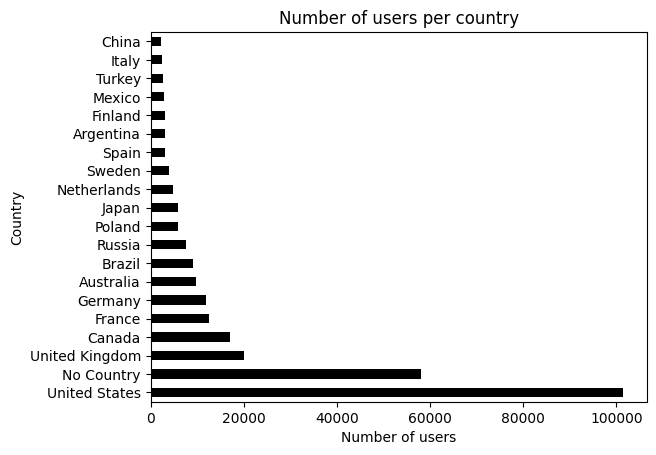

In [11]:
num_countries = 20
tmp_df = user_country_df.sort_values(by='number', ascending=False).head(num_countries)
tmp_df['country'].iloc[1] = "No Country"

ax = tmp_df.plot.barh(x='country', y='number', color='black')
ax.get_legend().remove()
ax.set_xlabel('Number of users')
ax.set_ylabel('Country')
ax.set_title('Number of users per country')

plt.show()

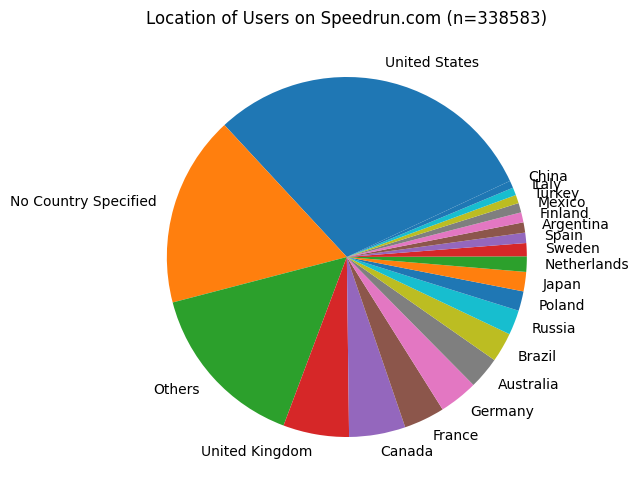

In [64]:
top_n_countries = 20
user_country_df.sort_values(by='number', ascending=False, inplace=True)
combined_user_country_df = user_country_df[:top_n_countries].copy()
tmp_df = pd.DataFrame(data={
    'country': ['Others'],
    'number': [user_country_df['number'][top_n_countries:].sum()],
})
combined_user_country_df = pd.concat([combined_user_country_df, tmp_df])
combined_user_country_df.sort_values(by='number', ascending=False, inplace=True)
combined_user_country_df.loc[172, 'country'] = "No Country Specified"
country_count = np.array(combined_user_country_df['number'])
labels = combined_user_country_df['country'].values.tolist()
plt.pie(country_count, labels=labels, startangle=25)
plt.tight_layout()
plt.title("Location of Users on Speedrun.com (n=338583)")
plt.show()

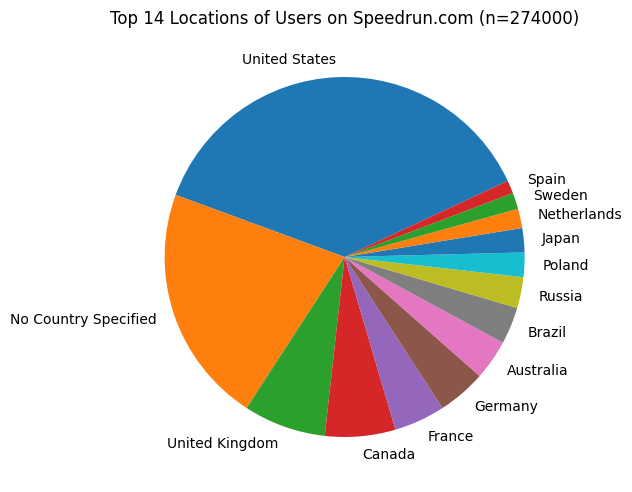

In [65]:
top_n_countries = 14
user_country_df.sort_values(by='number', ascending=False, inplace=True)
combined_user_country_df = user_country_df[:top_n_countries].copy()
combined_user_country_df.sort_values(by='number', ascending=False, inplace=True)
combined_user_country_df.loc[172, 'country'] = "No Country Specified"
country_count = np.array(combined_user_country_df['number'])
labels = combined_user_country_df['country'].values.tolist()
plt.pie(country_count, labels=labels, startangle=25)
plt.tight_layout()
plt.title("Top 14 Locations of Users on Speedrun.com (n=274000)")
plt.show()

In [23]:
del user_country_df, num_countries, ax, tmp_df

## Signup Date of Users of speedrun.com

After grouping the users by their signup date, we can see that **there is a regular ebb and flow in the signup rate of users**. We can also visualise the explosion in popularity around 2020, and **peaking in daily signups around New Years day 2021**. To explain the increases in daily signups, we plot the events of Summer Games Done Quick (SGDQ) and Awesome Games Done Quick (AGDQ) in green and red respectively. **In general, there is an increase in signups post-GDQ**. 

**The "mystery event" in October/November 2020 could be the explosion in popularity of games like Among Us during the COVID-19 lockdowns**. Looking at revenue percentage changes from the years of 2017 - 2027, we see that the revenue percentage increase is extremely high during 2020 [1]. 

[1] - https://www.statista.com/forecasts/1275485/revenue-growth-video-game-united-states  

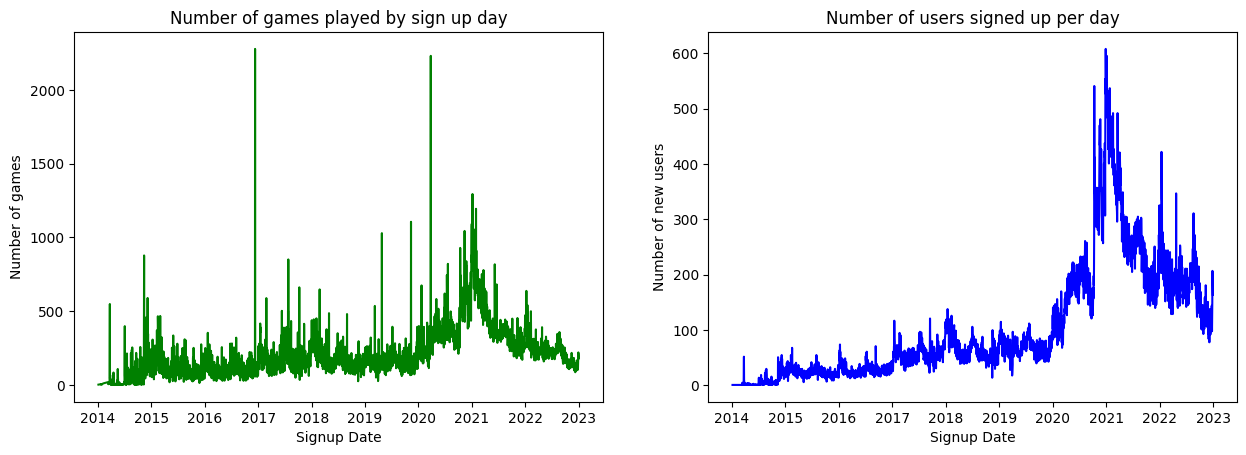

In [24]:
fig, ax = plt.subplots(1, 2)

df = user_prefs_df.copy().groupby(['signup_date']).sum().reset_index()
ax[0].plot(df['signup_date'], df['num_games'], color='green')
ax[0].set_xlabel("Signup Date")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Number of games played by sign up day")

df = user_prefs_df.copy().groupby(['signup_date']).count().reset_index()
ax[1].plot(df['signup_date'], df['user'], color='blue')
ax[1].set_xlabel("Signup Date")
ax[1].set_ylabel("Number of new users")
ax[1].set_title("Number of users signed up per day")

fig.set_figwidth(15)
plt.show()

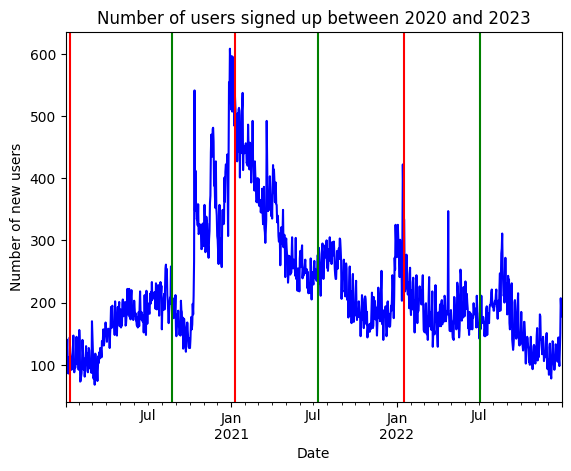

In [25]:
user_signup_2020_2023_df = df[(df['signup_date'] > '2020-01-01') & (df['signup_date'] < '2022-12-31')]

ax = user_signup_2020_2023_df.sort_values(by='signup_date').plot.line(x='signup_date', y='user', color='blue')

ax.axvline('2020-01-12', color='red')
ax.axvline('2021-01-10', color='red')
ax.axvline('2022-01-16', color='red')

ax.axvline('2020-08-23', color='green')
ax.axvline('2021-07-11', color='green')
ax.axvline('2022-07-03', color='green')

# What happened around here? I have no idea. Could be among us, fall guys, Dream, anything really.
# ax.axvline('2020-10-10', color='black')

ax.get_legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Number of new users")
ax.set_title("Number of users signed up between 2020 and 2023")
plt.show()

In [30]:
def find_top_n_countries(user_prefs_df: pd.DataFrame, n=10) -> tuple[pd.DataFrame, list[str]]:
    tmp_df = user_prefs_df.copy()
    tmp_df.reset_index(inplace=True)
    tmp_df['location'] = tmp_df['location'].str.upper()
    tmp_df.loc[tmp_df['location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'location'] = 'GB'
    tmp_df.loc[tmp_df['location'].isin(['CA', 'CA/QC']), 'location'] = 'CA'
    tmp_df.loc[tmp_df['location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'location'] = 'ES'
    return tmp_df, tmp_df.groupby('location').count().sort_values(by='user').tail(n).iloc[::-1].index.values.tolist()

In [31]:
tmp_df, top_countries = find_top_n_countries(user_prefs_df)
print(f"Top Countries: {top_countries}")

Top Countries: ['US', 'NONE', 'GB', 'CA', 'FR', 'DE', 'AU', 'BR', 'RU', 'PL']


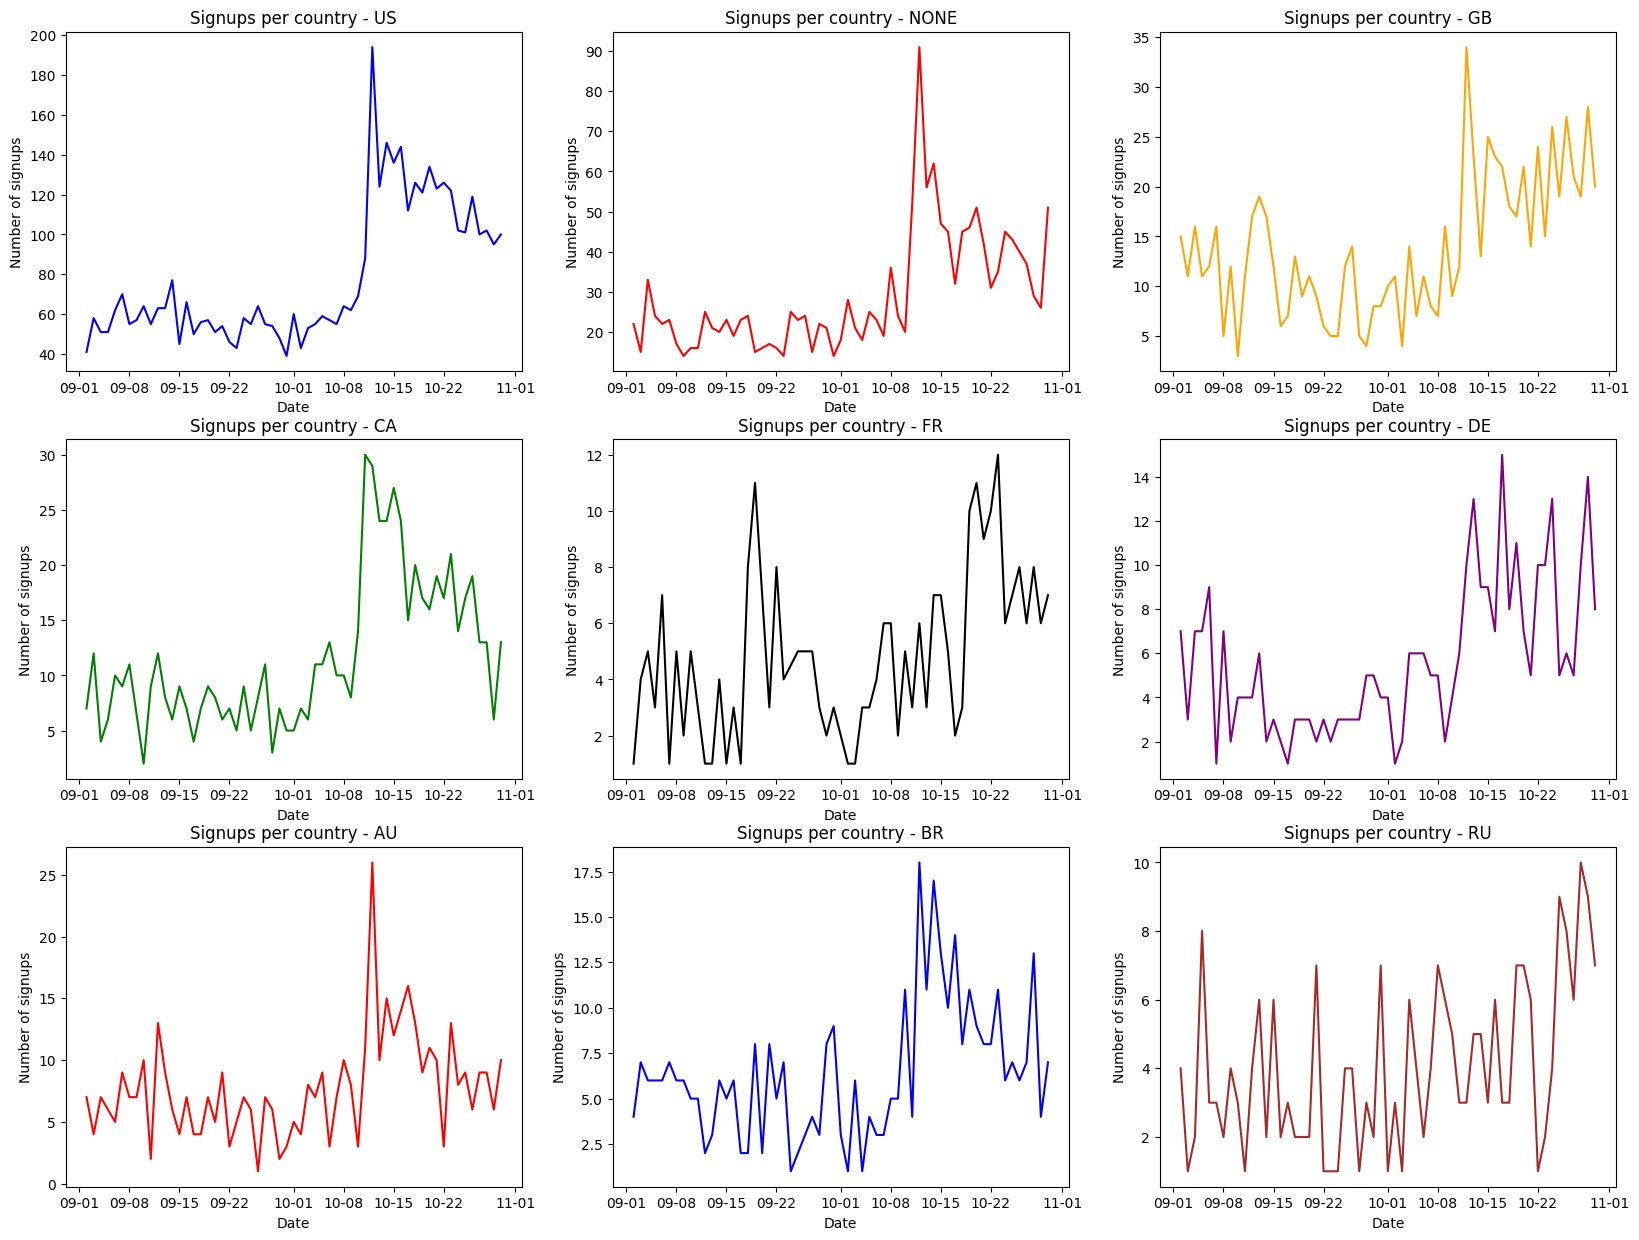

In [32]:
fig, ax = plt.subplots(3, 3)
colors = ['blue', 'red', 'orange', 'green', 'black', 'purple', 'red', 'blue', 'brown']

for index, top_country in enumerate(top_countries[:3]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[0, index].plot(df['signup_date'], df['user'], colors[index])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[0, index].xaxis.set_major_formatter(date_form)
    ax[0, index].set_title(f"Signups per country - {top_country}")
    ax[0, index].set_xlabel('Date')
    ax[0, index].set_ylabel('Number of signups')

for index, top_country in enumerate(top_countries[3:6]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[1, index].plot(df['signup_date'], df['user'], colors[index+3])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[1, index].xaxis.set_major_formatter(date_form)
    ax[1, index].set_title(f"Signups per country - {top_country}")
    ax[1, index].set_xlabel('Date')
    ax[1, index].set_ylabel('Number of signups')

for index, top_country in enumerate(top_countries[6:9]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[2, index % 3].plot(df['signup_date'], df['user'], colors[index+6])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[2, index].xaxis.set_major_formatter(date_form)
    ax[2, index].set_title(f"Signups per country - {top_country}")
    ax[2, index].set_xlabel('Date')
    ax[2, index].set_ylabel('Number of signups')
    
fig.set_figheight(15)
fig.set_figwidth(20)
plt.show()

In [33]:
del df, fig, ax, colors, user_signup_2020_2023_df, date_form

# Types of User on speedrun.com

After analysing the user present in the games network, we see that **there is a power law between the number of users that have played an amount of games**. Upon removing outliers from our data, we can see that **there are no obvious clusters present in the games played by users vs. the amount of time they have been on the platform**. There is also **no correlation between time registered and number of games played**. We can see that **player behaviour is very similar for 334,352 users**. This behaviour is that **for 99.99% of players, they have played less than 32 games**.

In [18]:
user_type_df = user_prefs_df.copy()
user_type_df['time_registered'] = (datetime(2023, 1, 1) - user_type_df['signup_date']) / np.timedelta64(1, 'D')

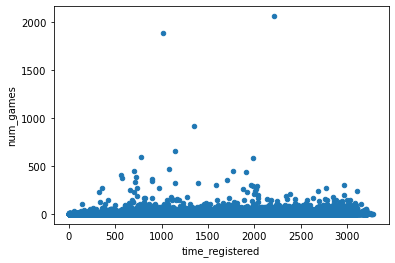

In [19]:
user_type_df.plot.scatter(x='time_registered', y='num_games')
plt.show()

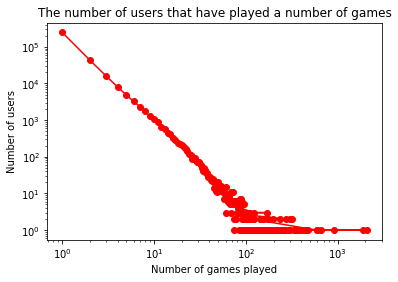

In [20]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
plt.loglog(num_games, num_users, 'ro-')
plt.xlabel("Number of games played")
plt.ylabel("Number of users")
plt.title("The number of users that have played a number of games")
plt.show()

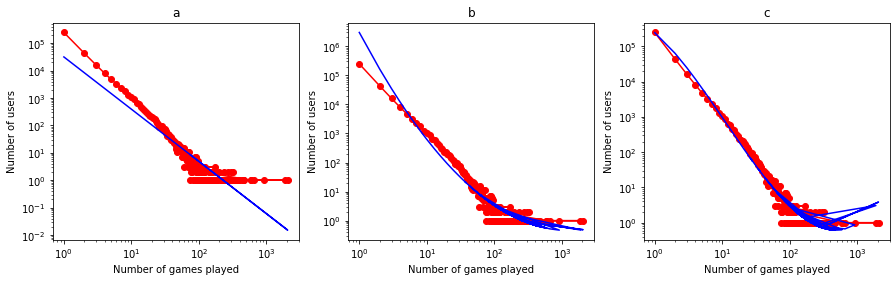

In [21]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
log_x = np.log(np.array(num_games))
log_y = np.log(np.array(num_users))

fig, ax = plt.subplots(1, 3)

a, b = np.polyfit(log_x, log_y, 1)
y_fit = np.exp(a*log_x + b)
ax[0].loglog(num_games, num_users, 'ro-')
ax[0].loglog(num_games, y_fit, 'b-')
ax[0].set_xlabel("Number of games played")
ax[0].set_ylabel("Number of users")
ax[0].set_title("a")

a, b, c = np.polyfit(log_x, log_y, 2)
y_fit = np.exp(a*log_x**2 + b*log_x + c)
ax[1].loglog(num_games, num_users, 'ro-')
ax[1].loglog(num_games, y_fit, 'b-')
ax[1].set_xlabel("Number of games played")
ax[1].set_ylabel("Number of users")
ax[1].set_title("b")

a, b, c, d = np.polyfit(log_x, log_y, 3)
y_fit = np.exp(a*log_x**3 + b*log_x**2 + c*log_x + d)
ax[2].loglog(num_games, num_users, 'ro-')
ax[2].loglog(num_games, y_fit, 'b-')
ax[2].set_xlabel("Number of games played")
ax[2].set_ylabel("Number of users")
ax[2].set_title("c")

fig.set_figwidth(15)
plt.show()

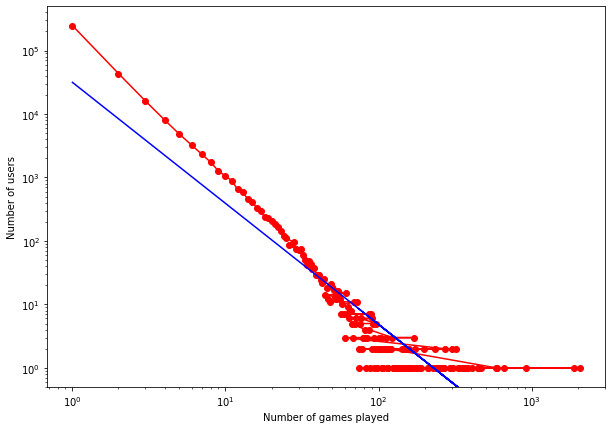

In [22]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
log_x = np.log(np.array(num_games))
log_y = np.log(np.array(num_users))

fig, ax = plt.subplots(1, 1)

a, b = np.polyfit(log_x, log_y, 1)
y_fit = np.exp(a*log_x + b)
ax.loglog(num_games, num_users, 'ro-')
ax.loglog(num_games, y_fit, 'b-')
ax.set_xlabel("Number of games played")
ax.set_ylabel("Number of users")
ax.set_ylim(ymin=0.5, ymax=max(num_users)*2)

fig.set_figheight(7)
fig.set_figwidth(10)
plt.show()


In [23]:
print(f"{a=}, {b=}, {np.exp(b)=}")
print(np.exp(b)*(1**a))

a=-1.9069834073094856, b=10.358571120395785, np.exp(b)=31526.10211947771
31526.10211947771


We have a power law in terms of $y=e^b * x^a$. Where $b=10.36$ (4 s.f.) and $a=-1.907$ (4 s.f.). This is simplified to $y=31526.10*x^{-1.91}$

Cutoff: 31.637231172266702


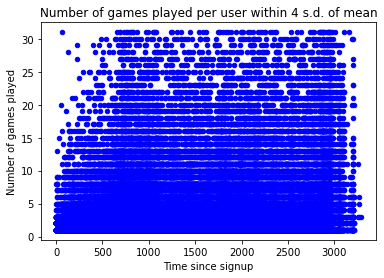

In [25]:
mean = user_type_df['num_games'].mean()
sd = user_type_df['num_games'].std()
n_std = 4

print(f"Cutoff: {mean+(n_std*sd)}")
ax = user_type_df[(user_type_df['num_games'] <= mean+(n_std*sd))].plot.scatter(x='time_registered', y='num_games', c='blue')
ax.set_ylabel("Number of games played")
ax.set_xlabel("Time since signup")
ax.set_title("Number of games played per user within 4 s.d. of mean")
plt.show()

In [26]:
user_type_df[(user_type_df['num_games'] <= mean+(n_std*sd))].describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games,time_registered
count,334352,334352,334352,334352.000000,334352,334352.000000
unique,334352,NaN,257,NaN,87836,NaN
top,8dw0vmlj,NaN,us,NaN,k6q4rqzd,NaN
freq,1,NaN,101050,NaN,5131,NaN
mean,NaN,2020-07-01 09:25:03.689524480,NaN,1.795889,NaN,913.607596
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN,1.000000
25%,NaN,2019-09-24 00:00:00,NaN,1.000000,NaN,462.000000
50%,NaN,2021-01-05 00:00:00,NaN,1.000000,NaN,726.000000
75%,NaN,2021-09-26 00:00:00,NaN,2.000000,NaN,1195.000000
max,NaN,2022-12-31 00:00:00,NaN,31.000000,NaN,3282.000000


Cutoff: 513.9403483488021


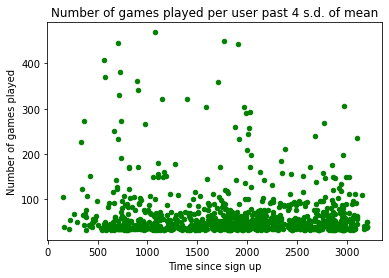

In [27]:
top_users_df = user_type_df[(user_type_df['num_games'] > mean+(n_std*sd))]
mean = top_users_df['num_games'].mean()
sd = top_users_df['num_games'].std()
n_std = 4

print(f"Cutoff: {mean+(n_std*sd)}")
ax = top_users_df[(top_users_df['num_games'] <= mean+(n_std*sd))].plot.scatter(x='time_registered', y='num_games', c='g')
ax.set_title("Number of games played per user past 4 s.d. of mean")
ax.set_xlabel("Time since sign up")
ax.set_ylabel("Number of games played")
plt.show()

In [28]:
top_users_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games,time_registered
count,970,970,970,970.000000,970,970.000000
unique,970,NaN,79,NaN,970,NaN
top,j5wzz2qj,NaN,us,NaN,"kdk9lx6m,pd0qj3l1,pdv2j746,kdkm93e1,y655m8e6,7...",NaN
freq,1,NaN,389,NaN,1,NaN
mean,NaN,2017-10-29 17:29:34.020618752,NaN,70.442268,NaN,1889.271134
min,NaN,2014-03-25 00:00:00,NaN,32.000000,NaN,147.000000
25%,NaN,2015-11-10 06:00:00,NaN,36.000000,NaN,1152.750000
50%,NaN,2017-09-05 12:00:00,NaN,45.000000,NaN,1943.500000
75%,NaN,2019-11-05 06:00:00,NaN,66.000000,NaN,2608.750000
max,NaN,2022-08-07 00:00:00,NaN,2059.000000,NaN,3204.000000


In [29]:
del top_users_df, mean, sd, n_std, a, b, c, d, fig, ax, num_games, num_users, log_x, log_y, user_type_df, y_fit

## Games that Users play on speedrun.com

We find that there are **246,995 players that have only played one game on speedrun.com**. **The games that these players play are Seterra, Minecraft-related games, ROBLOX-related games, Nintendo games, and 'typical speedrun' games**. 

We can see that **out of 43,367 users that have played strictly two games, the most popular combination is `nd2e9erd, j1npme6p`**. These are Minecraft: Java Edition category extensions, and Minecraft: Java Edition respectively. The combination of `o1ymwk1q, o1y9wo6q` represents Super Mario 64 and it's category extensions respectively. **These combinations seem to be either a game and it's category extensions, a game and it's sequel, or two games related to a single entity**. An example of the last one is Hypixel Bridging and Hypixel Bedwars.

### Games for Users that have Played One Game

In [30]:
one_game_user_df = user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'})
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns = {'game_id': 'id'})
one_game_user_df = one_game_user_df.groupby('id').count().reset_index()
merged_df = one_game_user_df.merge(games_metadata_df, on='id', how='inner')

In [31]:
user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'}).count()['user']

246995

In [32]:
user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'}).groupby('id').count().reset_index().sum()['user']

246995

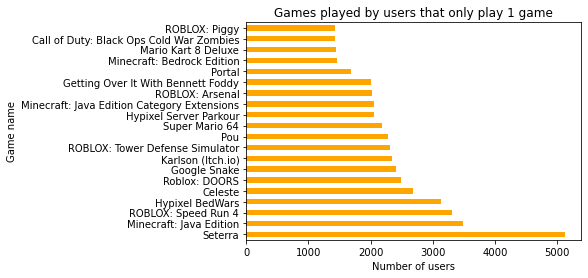

In [33]:
number_of_values = 20
merged_df = merged_df[['game_name', 'num_games']].sort_values(
    by='num_games').tail(number_of_values).iloc[::-1]
ax = merged_df.plot.barh(x='game_name', y='num_games', color='orange')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Games played by users that only play 1 game")
ax.get_legend().remove()
plt.show()

### Games for Users that have played Only Two Games

In [34]:
two_game_user_df = user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'})
two_game_user_df = two_game_user_df.groupby('id').count().reset_index()
two_game_user_df = two_game_user_df[['id', 'num_games']].sort_values(by='num_games').tail(number_of_values).iloc[::-1]

In [35]:
user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'}).count()['user']

43367

In [36]:
user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'}).groupby('id').count().reset_index().sum()['user']

43367

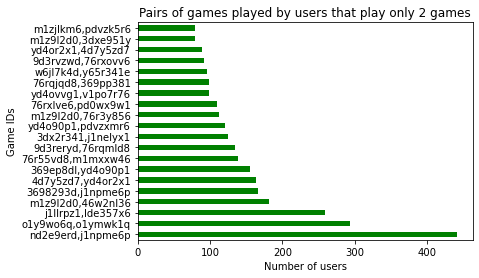

In [37]:
ax = two_game_user_df.plot.barh(x='id', y='num_games', color='green')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
ax.set_title("Pairs of games played by users that play only 2 games")
plt.show()

### Overrall Most Popular Games

In [38]:
games_df = user_prefs_df.copy()
games_df['games'] = games_df['games'].str.split(',')
games_df = games_df.explode('games').rename(columns = {'games': 'id'})
games_df = games_df.groupby('id').count().reset_index().sort_values(by='num_games').tail(20).iloc[::-1]

In [39]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
games_df = games_df.merge(games_metadata_df, on='id', how='inner')

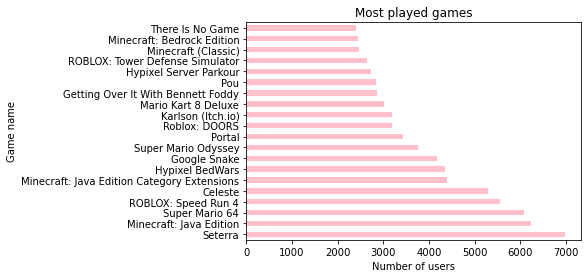

In [40]:
ax = games_df.plot.barh(x='game_name', y='num_games', color='pink')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most played games")
plt.show()

### Games Played by Users Within 3 s.d. of Mean

In [102]:
mean = user_prefs_df['num_games'].mean()
sd = user_prefs_df['num_games'].std()
n_std = 3
bottom_games_df = user_prefs_df[(user_prefs_df['num_games'] <= mean+(sd*n_std))].copy()
print(f"Number of users: {bottom_games_df.count()['user']}")

Number of users: 333751


In [103]:
bottom_games_df['games'] = bottom_games_df['games'].str.split(',')
bottom_games_df = bottom_games_df.explode('games').rename(columns = {'games': 'id'})
bottom_games_df = bottom_games_df.groupby('id').count().reset_index().sort_values(by='num_games')

In [104]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
merged_df = bottom_games_df.merge(games_metadata_df, on='id', how='inner')
merged_df.tail().iloc[::-1]

,id,user,signup_date,location,num_games,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
27433,k6q4rqzd,6817,6817,6817,6817,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
27432,j1npme6p,6186,6186,6186,6186,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491
27431,o1y9wo6q,5844,5844,5844,5844,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
27430,pd0py36e,5474,5474,5474,5474,ROBLOX: Speed Run 4,yzol0kzq,2013-01-01,2015-10-14T00:39:39Z,9,33,11303,5636,20
27429,o1y9j9v6,5161,5161,5161,5161,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14


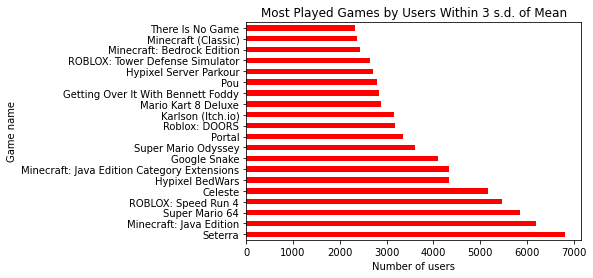

In [105]:
ax = merged_df.tail(20).iloc[::-1].plot.barh(x='game_name', y='user', color='red')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most Played Games by Users Within 3 s.d. of Mean")
plt.show()

### Games Played by Users Outside of 3 s.d. of Mean

In [106]:
mean = user_prefs_df['num_games'].mean()
sd = user_prefs_df['num_games'].std()
n_std = 3
top_games_df = user_prefs_df[(user_prefs_df['num_games'] > mean+(sd*n_std))].copy()
print(f"Number of users: {top_games_df.count()['user']}")

Number of users: 1571


In [107]:
top_games_df['games'] = top_games_df['games'].str.split(',')
top_games_df = top_games_df.explode('games').rename(columns = {'games': 'id'})
top_games_df = top_games_df.groupby('id').count().reset_index().sort_values(by='num_games')

In [108]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
merged_df = top_games_df.merge(games_metadata_df, on='id', how='inner')
merged_df.tail().iloc[::-1]

,id,user,signup_date,location,num_games,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
21240,o1y9wo6q,229,229,229,229,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
21239,om1m3625,203,203,203,203,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31
21238,pd0wq31e,178,178,178,178,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38
21237,9d3rr0dl,166,166,166,166,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46
21236,k6q4rqzd,162,162,162,162,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36


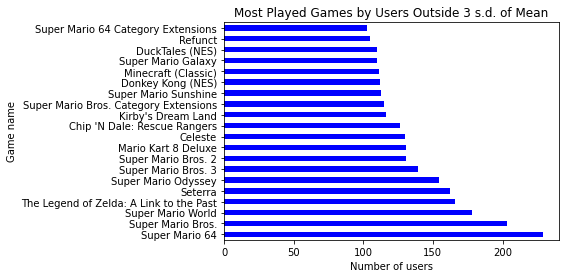

In [109]:
ax = merged_df.tail(20).iloc[::-1].plot.barh(x='game_name', y='user', color='blue')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most Played Games by Users Outside 3 s.d. of Mean")
plt.show()

In [71]:
del ax, games_df, merged_df, games_metadata_df, number_of_values, one_game_user_df, two_game_user_df

## General Community Detection of Users on speedrun.com

Here we are running the same three community detection algorithms (clauset-newman-moore, infomap, louvain) on a bipartite graph of users and the games that those users have played. We can see that **there are over 1000 communities found**. Examples of the louvain communities are the following:

 1. Number 550 (22,209 users): Mario games.
 2. Number 24 (21,887 users): Easy speedrun games? This contains most users that are past the 4 s.d. of number of games played.
 3. Number 623 (21,031 users): Nintendo games. This also contains a lot of users that have played lots of games.
 4. Number 624 (21,004 users): Roblox games. 
 5. Number 605 (14,092 users): Games with a cartoon style, such as SpongeBob Square Pants, Spyro, Crash Bandicoot, Banjo-Kazooie, The Simpsons, Ratchet and Clank
 6. Number 1042 (13,566 users): Resident Evil, Metal Gear Solid, Dark Souls, Tomb Raider, Silent Hill, PlayStation games
 7. Number 901 (11,875 users): Celeste, Hollow Knight, Super Meat Boy, Spelunky. Popular indie games.
 8. Number 204 (11,643 users): Popular AAA games.
 9. Number 894 (10,779 users): Minecraft games.
 10. Number 1038 (10,004 users): Hypixel minigames.
 11. Number 849 (8,772 users): Mario games (again?)
 12. Number 722 (7,807 user): More minecraft games.
 13. Number 542 (7,051 users): Call of Duty games.
 14. Number 593 (6,412 users): Online/Web games.
 15. Number 934 (6,203 users): I have no idea.

In [308]:
user_prefs_df = pd.read_csv("../data/users/user_preferences_with_metadata.csv").rename(columns={'user': 'id'})
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (user_prefs_df['signup_date'] != "Null")]
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'] < '2023-01-01')]

In [467]:
user_cluster_df = pd.read_csv('../data/users/infomap_communities.csv').rename(columns={'node_id': 'id'})
games_metadata_df = pd.read_csv('../data/games/metadata/all_games_srcom.csv').rename(columns={'game_id': 'id'})
games_merged_df = games_metadata_df.merge(user_cluster_df, on='id', how='inner')
user_merged_df = user_prefs_df.merge(user_cluster_df, on='id', how='inner')

In [468]:
user_merged_df.groupby('community_num').count().rename(columns={'id': 'num_users'}).sort_values(by='num_users', ascending=False).head(15)[['num_users']]

,num_users
community_num,
0,109410
1,42676
3,32675
4,30321
2,27940
5,13210
6,9687
7,9220
8,5780


In [488]:
num_community = 2

In [489]:
user_merged_df[user_merged_df['community_num'] == num_community].sort_values(by='num_games', ascending=False).head(10)

,id,signup_date,location,num_games,games,community_num
2615,y8dzlz9j,2019-04-26,us,916,"46w3pn31,m1zrx3d0,kdk9lx6m,9dow05o1,y65k0e6e,m...",2
2661,68wne448,2019-11-11,br,658,"yd4k9x6e,2688056p,j1n5wl1p,yd43mp1e,j1n8nne1,2...",2
298,j0n0vk48,2020-11-11,us,597,"kdkzexgd,lde58jd3,y654joed,kdk9lx6m,pdv27gr6,o...",2
1,zxzygl4j,2017-07-26,us,589,"kdk9lx6m,m1zjjx26,m1meg4d2,y65ey86e,j1neg91p,p...",2
2202,8ger577j,2020-01-22,us,469,"3dxrxydy,4d79e0l1,o6gg8n62,j1nee0l1,lderln63,o...",2
320,zxzzvlrx,2018-02-25,jp,450,"ldej04e1,2688056p,36985w2d,yd4kyn56,369820ld,p...",2
2667,98rzez3x,2019-11-11,br,321,"j1n5wl1p,j1n8nne1,lde33kx6,kdkmy3g1,kdkm93e1,y...",2
5569,y8d3z5x6,2014-11-14,us,305,"lde3wen6,3dxrxydy,m1zq7z10,m1zrx3d0,m1mg3k12,j...",2
27,qxk6eok8,2017-07-24,eo,291,"9donyo1p,y654k0ed,kdk9lx6m,m1mxnx36,m1zjjx26,k...",2
171,dx3gg78l,2015-06-01,None,269,"268wmk6p,4d785l67,v1px8p46,lde3v563,3698y3dl,o...",2


In [490]:
games_merged_df[games_merged_df['community_num'] == num_community].sort_values(by='num_runs', ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
3723,m1zoemd0,Super Metroid,"1zkdw96j,xv6dvx62,y4zw106k",1994-03-19,2016-11-25T20:23:44Z,11,0,11381,1232,379,2
1794,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,2
469,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,2
2288,9d3rr0dl,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46,2
16816,ldep0513,Final Fantasy XIV: Endwalker,qvegwk60,2013-08-24,2016-09-25T19:14:00Z,13,318,5290,926,1319,2
1032,l3dx51yv,Super Mario Bros. 3,xv6dvx62,1988-10-23,None,4,0,4393,1016,8,2
468,y658506e,Super Mario Bros. Category Extensions,None,1985-09-13,2016-11-05T05:30:59Z,43,0,4351,785,6,2
29312,3dxkz0v1,Metroid Dread,None,2021-10-08,2021-08-17T20:18:49Z,8,0,4350,1213,1,2
26240,76rxmxq6,Streets of Rage 4,"4zwny0zk,rzjqd7el",2020-04-30,2020-05-02T06:58:42Z,19,21,3403,280,34,2
23591,lde3k956,The Messenger,yz8m996w,2018-08-30,2018-08-30T14:46:37Z,5,0,3018,436,1,2


In [491]:
tmp_df = user_merged_df[user_merged_df['community_num'] == num_community].copy()
tmp_df['games'] = tmp_df['games'].str.split(',')
tmp_df = tmp_df.explode('games').rename(columns = {'games': 'game_id'})
tmp_df = tmp_df.groupby('game_id').count().reset_index().sort_values(by='num_games', ascending=False).head(20)
games_metadata_df = pd.read_csv('../data/games/metadata/all_games_srcom.csv')
tmp_df = tmp_df.merge(games_metadata_df, on='game_id', how='inner')

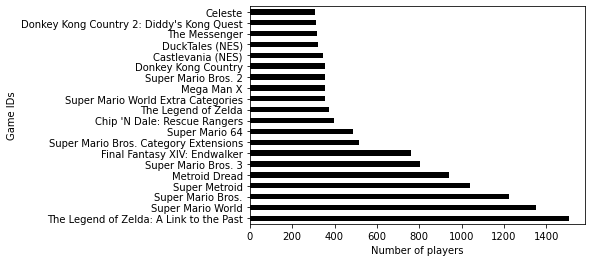

In [492]:
ax = tmp_df.plot.barh(x='game_name', y='num_games', color='black')
ax.set_xlabel("Number of players")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
plt.show()

## Connected Components in User-Game Bipartite Network

There are over 1000 connected components in this bipartite network. **We see that the largest connect components contain $99.28%$ of the network**. The other components are found by a set of users only playing a single game, or a set of users only playing a few games. We can say that these kind of players are outliers.

In [50]:
def create_exploded_users_df(filename: str) -> pd.DataFrame:
    user_prefs_df = pd.read_csv(filename)
    user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (
        user_prefs_df['signup_date'] != "Null")]
    user_prefs_df['signup_date'] = pd.to_datetime(
        user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    user_prefs_df['signup_date'] = pd.to_datetime(
        user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
    user_prefs_df = user_prefs_df[(
        user_prefs_df['signup_date'] < '2023-01-01')]
    exploded_games_df = user_prefs_df.copy()
    exploded_games_df['games'] = exploded_games_df.copy()[
        'games'].str.split(',')
    exploded_games_df = exploded_games_df.explode('games').rename(
        columns={'games': 'game_id', 'user': 'user_id'})[['user_id', 'game_id']]
    return exploded_games_df


def create_bipartite_user_graph(df: pd.DataFrame) -> nx.Graph:
    bipartite_graph = nx.Graph()
    bipartite_graph.add_nodes_from(set(df['user_id'].values), bipartite=0)
    bipartite_graph.add_nodes_from(set(df['game_id'].values), bipartite=1)
    bipartite_graph.add_edges_from(
        [(user, game) for user, game in zip(df['user_id'], df['game_id'])])
    assert nx.is_bipartite(bipartite_graph)
    return bipartite_graph

In [380]:
df = create_exploded_users_df("../data/users/user_preferences_with_metadata.csv")
bipartite_graph = create_bipartite_user_graph(df)

In [381]:
games_metadata_df = pd.read_csv('../data/games/metadata/all_games_srcom.csv').rename(columns={'game_id': 'id'})
components = sorted([component for component in nx.connected_components(bipartite_graph)], key=len, reverse=True)
print(f"Number of components in bipartite graph: {len(components)}")
print(f"Biggest component in bipartite graph: {len(max(components, key=len))}")
print(f"Total number of nodes in bipartite graph: {bipartite_graph.order()}")


Number of components in bipartite graph: 1039
Biggest component in bipartite graph: 364123
Total number of nodes in bipartite graph: 366747


In [399]:
games_list = components[9]
games_metadata_df[(games_metadata_df['id'].isin(games_list))]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
24602,76r3rqq6,King of the Hat,p6xp7xz1,2018-09-27,2022-07-02T23:09:11Z,4,0,26,7,0


In [400]:
user_prefs_df[(user_prefs_df['id'].isin(games_list))]

,id,signup_date,location,num_games,games
289117,jpon6gk8,2022-07-04T23:25:52Z,NONE,1,76r3rqq6
289118,jm3rqpz8,2022-06-16T12:40:35Z,US,1,76r3rqq6
289119,j2w5d4lj,2021-03-12T17:13:33Z,FI,1,76r3rqq6
289120,jm3r4m48,2022-06-16T20:25:39Z,NONE,1,76r3rqq6
289121,xym212mx,2022-06-16T20:02:33Z,NONE,1,76r3rqq6
289122,jn2l4l1j,2022-07-04T01:22:55Z,CA,1,76r3rqq6
289123,8r7pzyqj,2020-12-22T10:14:12Z,FI,1,76r3rqq6


## Bipartite Community Detection Algorithms of Users on speedrun.com

**TL;DR —— There are communities that are focused on game series (Mario, Sonic, Minecraft, ROBLOX), others are based on the platforms (Nintendo consoles, PlayStation, Web, Mobile, PC), the genre of game (open-world, platformers, souls-like, first-person shooters, role-playing games, horror), or the developmers (Valve, Nintendo, Indie developers, AAA publishers). Most communities are built around multiple games that are related in some fashion, but some are surrounding very few games. These games are Seterra, Pou, ROBLOX: Tower Defense Simulator, ROBLOX: Arsenal. The communities that have high amount of users but low number of games are usually around web/mobile games.**

We have around 1,000 communities. Here's a breakdown of the notable communities:

 * Community 0: This is largest community by number of users. **This community is centered around Mario and Nintendo games, but more modern games than the ones in community one**. We can see that the users in this community also play typical speedrunning games such as Celeste, Portal, Refunct, and Minecraft: Java Edition.
 * Community 1: This contains the second most amount of users but a very large number of games played for that many users. We see that **the players in this community play older games— ones released for the NES of Nintendo 64 (N64)**. We see that most of the top games are taken by Mario games. It is important to note that **these games are usually played on the actual consoles and not via emulation**. This is an important distinction when other communities are characterised by their games being played on PC.
 * Community 2: This contains the second most amount of users. This community contains the speedrunners that have played the most games (as mentioned earlier). This community is characterised by games that have a very low barrier to entry — Crossy Road, Seterra, Slither.io, ROBLOX, Among Us, Piano Tiles. **The games in this category can be characterised as mobile or online games**. We can also see lots of typical speedrunning games in here as well, but we expect these to be in every category (to some degree) because of their extreme popularity.
 * Community 3: This community is characterised by ROBLOX games and other web games.
 * Community 4: The games in this community are Resident Evil or Souls-games. Looking deeper however **this category may represent video games released on the Playstation platforms**. Despite not being a popular game, we see The Last of Us, God of War, Uncharted, and Horizon on here. These games are playstation exlusives. We also see specific Console version of games, but similarly we see specific Steam (PC) versions too.
 * Community 5: The top games in this community are all developed by Valve. There are a few others (Superliminal, Dishonored, Mirror's Edge, and Antichamber) which are not. **My hypothesis for this category is games that are majority speedrun on PC**. We see games like Super Mario 64 and Super Mario Odyssey in here, but those are in the minority.
 * Community 6: This community is mostly puzzle/platformer games with some action-adventure/adventure games.
 * Community 7: This community is mostly minecraft and mincraft-adjacent games, such as minigames or mods.
 * Community 8: This community can be categorised by minecraft-adjacent games and minigames. This includes games such as hypixel, custom maps, and different servers. 
 * Community 9: This community contains games developed by Rockstar games, open-world games, car games, "Tony Hawk's" series of games. **My theory as to why this particular community was found is because of the open-world games**, with Rockstar games making (basically) *only* open-world games.
 * Community 10: This community is all Minecraft-adjacen games (again). I'm not sure what differentiates this community from community 7 and 8, **further investigation is required**. There are a few web-only and mobile games in this category as well. 
 * Community 11: This community is mostly platformers and roguelikes. **These are also mostly indie games -- few games being published by large development studios**. 
 * Community 12: The games in this community are almost all exclusively from the Call of Duty franchise. There also a few others (that are statistically significant) such as FrostRunner (first-person platformer), Doritos Crash Course (2 1/2 D platformer), Smite (top-down MMO), and Mount & Blade: Warband (strategy action game). **Most of the games in this category are first-person shooters**. 
 * Community 13: The top games in this community can all be found on [itch.io](https://itch.io), a service for distributing Indie games. This is also combined with other online games such as Google Snake, Seterra, and Minecraft.
 * Community 14: This community is comprised of Final Fantasy, Kingdom Hearts, Xenoblade Chronicals. **Broadly this category can be labelled as role-playing games**.
 * Community 15: The games in this category can be defined as free to play, or they could be labelled as web games.
 * Community 16: This community has games such as Crash Bandicoot, Spyro, Harry Potter, Yu-Gi-Oh!, and Rayman. **I'm tempted to label this category as cartoon games plus Harry Potter**.
 * Communtiy 17: **This category is the fourth lowest in average number of games played by users**. **This is probably due to Seterra**, the rest of the games are pretty statistically insignificant. As a betting man, there's probably very little correlation between the other games. Saying that, **the other games are mostly web games, or Minecraft-adjacent**.
 * Communtiy 18: The most popular games in this community are horror-themed. The game SELF is characterised as 'Kafkaesque' which is *VERY* strange.
 * Communtiy 19: This community is mostly `ROBLOX: Tower Defense Simulator`, but can be generally categorised as ROBLOX games.
 * Communtiy 20: This community is mostly `Getting Over It With Benett Foddy`. **Looking at the other games they can be categorised as 'climbing games'**, but also contains games such as GeoGuessr, Appel, Golf with your friends —— Usually other web games.
 * Communtiy 21: Multiplayer RPG shooter games. 
 * Communtiy 22: **The majority of this category is Deltarune and Undertale. These are both by the same person!** We also see the "Five Night's at Freddy's" franchise, and Club Penguin. We also see `The Very Orgnized Thief` which is self-described as FNAF-like gameplay.
 * Communtiy 23: This community is mostly Hitman or Payday games. We see other similar games such as the "Tom Clancy" game series or The Division. **We can probably label this category as Shooting/Action games**.
 * Communtiy 24: This community is *definitely* Sonic games.
 * Communtiy 25: There are lots of **very popular games in this category but they are not traditionally speedrunnable**. This is games such as Overwatch, Valorant, Among Us, Apex Legends, FIFA, Brawlhalla, etc.
 * Communtiy 26: This category is horror games.
 * Communtiy 27: Pokémon games! also `Old School Runescape`.
 * Communtiy 28: Games that come bundled with Windows,. Also contains tabletop games, and games set or made in Japan.
 * Communtiy 29: This community is basically only Pou, a modern day tamagotchi type-vibe. **The games are all mobile games**.
 * Community 30: These are classic web games — Bloons, Duck Life, Learn to Fly, Age of War, Papa's Pizzeriam, Stick War, Earn to Die. 
 * Communtiy 31: These are mostly cartoon web games: Henry Stickmin, There Is No Game, Age of War, Riddle School, etc. Path of Exile is in here but doesn't really fit with anything else in the category. 
 * Community 32: Spongebob games, little big planet, and other cartoon tie-in games such as Jimmy Neutron, Shrek, Phineas and Ferb, Nicktoons, Ice Age, etc.
 * Community 33: LEGO games, Batman series, Spiderman games. In general these can probably be categorised as fantasy/fantasy tie-in games. This also contains other seemingly random games such as Poptropica (?), Neon Boost, Rust, and Cities: Skylines.
 * Community 34: Games that are available both on mobile and PC, and the Cube Escape franchise.
 * Community 35: Series such as Ratchet and Clank, Jak and Daxter, Sly Cooper, Skylanders, DS and GBA games, not sure how to define the others.

Past category 27 there are less than 1% of all users in a category. Our aim is to categorise the behaviour of users on speedrun.com, and these categories *could* be defined as outliers. The list above is not ordered by number of users ^

In [166]:
def create_exploded_users_df(filename: str) -> pd.DataFrame:
    user_prefs_df = pd.read_csv(filename)
    user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (user_prefs_df['signup_date'] != "Null")]
    user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
    user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
    user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'] < '2023-01-01')]
    exploded_games_df = user_prefs_df.copy()
    exploded_games_df['games'] = exploded_games_df.copy()['games'].str.split(',')
    exploded_games_df = exploded_games_df.explode('games').rename(columns={'games': 'game_id', 'user': 'user_id'})[['user_id', 'game_id']]
    return exploded_games_df

def create_bipartite_user_graph(df: pd.DataFrame) -> nx.Graph:
    bipartite_graph = nx.Graph()
    bipartite_graph.add_nodes_from(set(df['user_id'].values), bipartite=0)
    bipartite_graph.add_nodes_from(set(df['game_id'].values), bipartite=1)
    bipartite_graph.add_edges_from(
        [(user, game) for user, game in zip(df['user_id'], df['game_id'])])
    assert nx.is_bipartite(bipartite_graph)
    return bipartite_graph

def create_biadjacency_matrix(graph: nx.Graph) -> tuple[list[str], list[str], sparse.csr_matrix]:
    nodelist = list(graph.nodes(data='bipartite'))
    row_nodes = [node[0] for node in nodelist if node[1] == 0]
    col_nodes = [node[0] for node in nodelist if node[1] == 1]
    return row_nodes, col_nodes, sparse.csr_matrix(nx.bipartite.biadjacency_matrix(graph, row_order=row_nodes, column_order=col_nodes))

In [167]:
df = create_exploded_users_df("../data/users/user_preferences_with_metadata.csv")
bipartite_graph = create_bipartite_user_graph(df)
row_nodes, col_nodes, biadjacency_matrix = create_biadjacency_matrix(bipartite_graph)

In [168]:
louvain = Louvain(modularity='newman')
louvain.fit(biadjacency_matrix)
all_labels = np.concatenate((louvain.labels_row_, louvain.labels_col_))
all_nodes = np.concatenate((row_nodes, col_nodes))

In [169]:
community_df = pd.DataFrame({'id': all_nodes, 'community_num':all_labels})
games_metadata_df = pd.read_csv('../data/games/metadata/all_games_srcom.csv').rename(columns={'game_id': 'id'})
user_prefs_df = pd.read_csv('../data/users/user_preferences_with_metadata.csv').rename(columns={'user': 'id'})
user_prefs_df['location'] = user_prefs_df['location'].str.upper()
user_prefs_df.loc[user_prefs_df['location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'location'] = 'GB'
user_prefs_df.loc[user_prefs_df['location'].isin(['CA', 'CA/QC']), 'location'] = 'CA'
user_prefs_df.loc[user_prefs_df['location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'location'] = 'ES'
user_merged_df = user_prefs_df.merge(community_df, on='id', how='inner')
games_merged_df = games_metadata_df.merge(community_df, on='id', how='inner')

In [340]:
communities_df = user_merged_df.groupby('community_num').count().rename(columns={'id': 'num_users'}).reset_index()[['community_num', 'num_users']]
communities_df = communities_df.merge(games_merged_df.groupby('community_num').count().rename(columns={'id': 'num_games'}).reset_index()[['community_num', 'num_games']], on='community_num', how='inner')
communities_df['avg_num_games_played'] = communities_df['num_games'] / communities_df['num_users']
communities_df.set_index('community_num').sort_values(by='num_users', ascending=False).head(50)

,num_users,num_games,avg_num_games_played
community_num,,,
0,32565,2330,0.071549
2,22908,4673,0.203990
1,21415,7351,0.343264
3,17626,173,0.009815
4,13385,1436,0.107284
5,11785,1162,0.098600
6,11527,726,0.062983
7,10850,250,0.023041
8,9980,92,0.009218


In [408]:
num_community = 40

In [407]:
user_merged_df[user_merged_df['community_num'] == num_community].sort_values(by='num_games', ascending=False).head(5)

,id,signup_date,location,num_games,games,community_num
74223,jm3q0py8,2022-06-23T19:43:40Z,BR,10,"k6qwnnm6,nd28kkqd,m1mky3d2,kdkmgnq1,ldelvl63,k...",29
68729,xymgz9yx,2022-07-06T20:06:24Z,BR,9,"pdv2wwk6,k6qwnnm6,m1mky3d2,w6jn7x1j,ldelvl63,4...",29
74300,jpoepw08,2022-07-14T19:09:03Z,BR,8,"k6qwnnm6,nd28kkqd,m1mky3d2,kdkmgnq1,ldelvl63,n...",29
30083,8qolewoj,2022-08-05T15:00:53Z,BR,7,"m1mky3d2,kdkmgnq1,ldelvl63,nd28k2ed,2687r9dp,9...",29
10199,8g531mrj,2021-12-25T19:17:22Z,US,7,"pdv2wwk6,j1n8p9e1,lde3e3e6,3dxkzjy1,9do79k6p,3...",29


In [409]:
games_merged_df[games_merged_df['community_num'] == num_community].sort_values(by='num_runs', ascending=False).head(5)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
19117,yd4ojyk1,ROBLOX: Arsenal,4epw896r,2015-08-18,2020-05-18T17:20:13Z,19,40,9459,2330,5,40
22626,j1n84xx1,Reminiscence,None,2018-01-11,2021-07-20T14:46:11Z,1,0,18,7,0,40
27617,o1yjnlo1,ION FORMULA RACING 2021,qe542lzv,2020-12-26,2022-04-04T11:06:35Z,4,11,6,4,1,40
30123,m1zklz31,Equinoxe,None,2022-02-18,2022-02-28T18:35:39Z,2,0,3,3,0,40


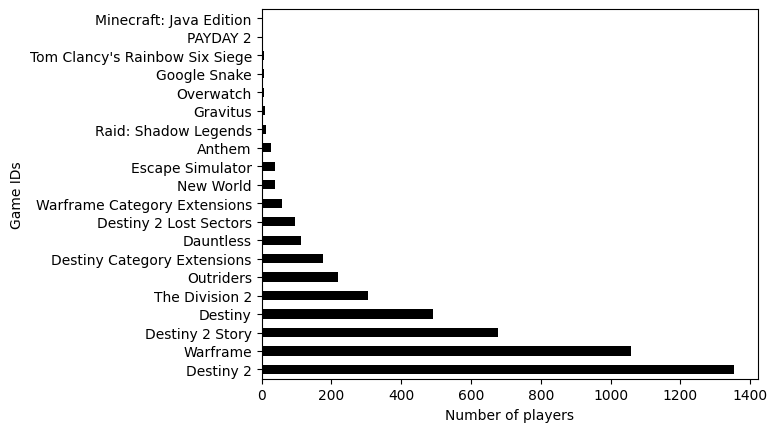

[['Destiny 2', 1353],
 ['Warframe', 1059],
 ['Destiny 2 Story', 676],
 ['Destiny', 492],
 ['The Division 2', 305],
 ['Outriders', 218],
 ['Destiny Category Extensions', 177],
 ['Dauntless', 114],
 ['Destiny 2 Lost Sectors', 97],
 ['Warframe Category Extensions', 60],
 ['New World', 39],
 ['Escape Simulator', 38],
 ['Anthem', 26],
 ['Raid: Shadow Legends', 12],
 ['Gravitus', 11],
 ['X Hero Siege', 5],
 ['Godfall', 3],
 ['Farming Simulator 2011', 3],
 ['Warcraft Adventures: Lord of the Clans', 2],
 ['Claybook', 2],
 ['TT Isle of Man Ride on the Edge 2', 2],
 ["Atlas' Fate: Between Light And Darkness", 2],
 ['Suit For Hire', 2],
 ['MX vs. ATV All Out', 1],
 ['Onyx Clad', 1]]

In [404]:
tmp_df = user_merged_df[user_merged_df['community_num'] == num_community].copy()
tmp_df['games'] = tmp_df['games'].str.split(',')
tmp_df = tmp_df.explode('games').rename(columns = {'games': 'game_id'})
tmp_df = tmp_df.groupby('game_id').count().reset_index().sort_values(by='num_games', ascending=False)
games_metadata_df = pd.read_csv('../data/games/metadata/all_games_srcom.csv')
tmp_df = tmp_df.merge(games_metadata_df, on='game_id', how='inner')
ax = tmp_df.head(20).plot.barh(x='game_name', y='num_games', color='black')
ax.set_xlabel("Number of players")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
plt.show()
tmp_df
tmp_df[(tmp_df['game_id'].isin(games_merged_df[games_merged_df['community_num']== num_community]['id'].values.tolist()))][['game_name', 'id']].values.tolist()


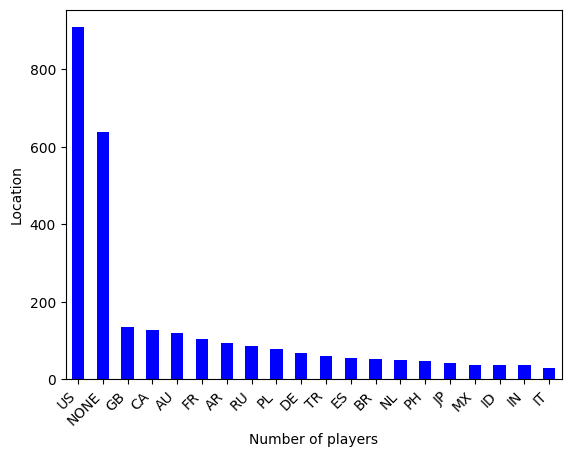

In [320]:
tmp_df = user_merged_df[user_merged_df['community_num'] == num_community].copy()
tmp_df = tmp_df.groupby('location').count().reset_index().sort_values(by='num_games', ascending=False).head(20)
ax = tmp_df.plot.bar(x='location', y='num_games', color='blue')
ax.set_xlabel("Number of players")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Location")
ax.get_legend().remove()
plt.show()